In [1]:
import pandas as pd
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Set-up Model Parameters

In [2]:
# load mobility matrix
data = pd.read_csv('../../../Dropbox/Epidemiology/trajectories/nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 3)
tmat.add_transition('A', 'I', 3, 3)
tmat.add_transition('I', 'R', 14, 5)
print(tmat.value)
np.sum(tmat.value, axis=1)

[[0.8        0.2        0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


array([1., 1., 1., 1.])

In [4]:
# starting fractions probabilities
start = np.zeros((M,)) - 10 #anywhere
start[0] = 5. # but likely 0

## Make starting joint

In [5]:
param_model = maxentep.ParameterJoint(start, R, tmat, name='unbiased')

## Examine some of the statistics

In [6]:
v = param_model.sample(100)

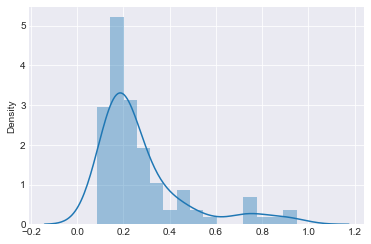

In [7]:
x = v[1][:,compartments.index('E'), compartments.index('A')].numpy()
sns.distplot(x=x)
plt.show()

In [8]:
np.mean(v[1][:, 0, 1]), 1/5

(0.2737197, 0.2)

In [9]:
v[3][4]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.13946031], dtype=float32)>

In [10]:
# check transition matrix is valud
T = v[1][0].numpy()
print(T)
f = [0.1,0,0,0]
for i in range(1000):
    f = f @ T
    if i % 100 == 0:
        print(f, np.sum(f))

[[0.85027635 0.14972362 0.         0.        ]
 [0.         0.6629298  0.3370702  0.        ]
 [0.         0.         0.87773067 0.12226934]
 [0.         0.         0.         1.        ]]
[0.08502764 0.01497236 0.         0.        ] 0.09999999701976776
[7.68369481e-09 6.14065445e-09 1.55335089e-06 9.99984102e-02] 0.099999977347025
[6.94352675e-16 5.54912702e-16 3.52485420e-12 9.99999773e-02] 0.09999997734711777
[6.27465886e-23 5.01458125e-23 7.65723751e-18 9.99999773e-02] 0.09999997734711769
[5.67022283e-30 4.53152811e-30 1.66047695e-23 9.99999773e-02] 0.09999997734711767
[5.12401193e-37 4.09500734e-37 3.60048924e-29 9.99999773e-02] 0.09999997734711767
[4.63041737e-44 3.70053649e-44 7.80708390e-35 9.99999773e-02] 0.09999997734711767
[4.18437063e-51 3.34406490e-51 1.69284081e-40 9.99999773e-02] 0.09999997734711767
[3.78129144e-58 3.02193212e-58 3.67065351e-46 9.99999773e-02] 0.09999997734711767
[3.41704075e-65 2.73083029e-65 7.95922282e-52 9.99999773e-02] 0.09999997734711767



## Create set of trajectories
The loop is just to batch the trajectories. It is not necessary, just I have my at home GPU which has small RAM.
You could instead just pick `N = 16 * 256` and call once.

In [11]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 256
batches = 4
outs = []
timesteps = 360
infect_fxn = maxentep.contact_infection_func(infections_compartments)
model = MetaModel(infect_fxn, timesteps)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.51s/it]

(1024, 360, 62, 5)


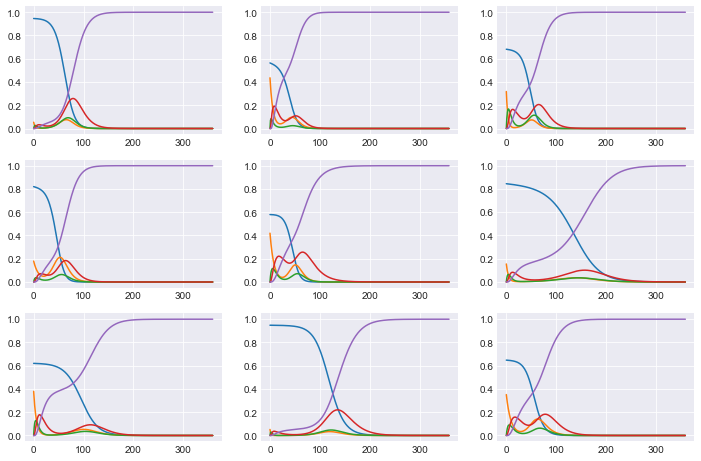

In [12]:
# plot a few trajectories
fig, ax = plt.subplots(3, 3, figsize=(12,8))
for i in range(3):
    for j in range(3):
        ax[i,j].plot(trajs[i * 3 + j,:,0,:])
plt.show()

## Make quantile Plots

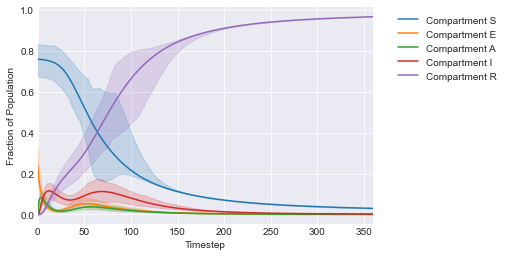

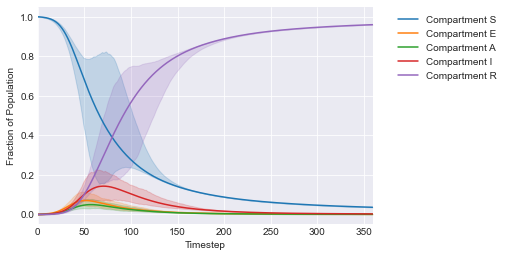

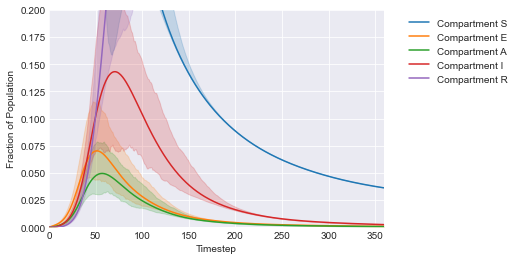

In [13]:
full_compartments = ['S'] + compartments
traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True)
plt.ylim(0,0.2)
plt.show()

## Create arbitrary restraints

In [14]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,300, 1, 4],
    [0.6, 0.1, 250, 34, 4],
    [0.4, 0.1, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxentep.Laplace(uncertainty)
    #p = maxentep.EmptyPrior()
    r = maxentep.Restraint(lambda traj,j=traj_index: traj[j], value, p)
    laplace_restraints.append(r)

## Use maxent model to fit

In [15]:
model = maxentep.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Nadam(learning_rate=1e-2), 'mean_squared_error')

In [16]:
history = model.fit(trajs, batch_size=16, epochs=10, verbose=0)

In [17]:
model.summary()

Model: "maxent-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reweight_layer_laplace (Rewe multiple                  5         
_________________________________________________________________
avg_layer_laplace (AvgLayerL multiple                  5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


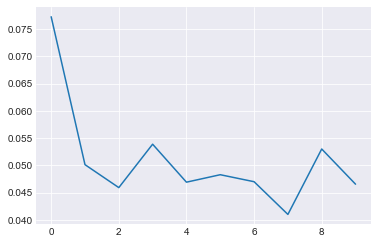

In [18]:
plt.plot(history.history['loss'])

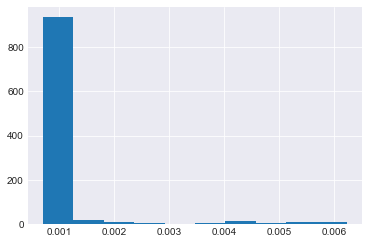

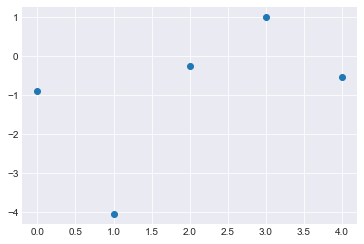

In [19]:
weights = model.traj_weights
plt.hist(weights)
plt.show()
plt.plot(model.lambdas.numpy(), 'o')

## Complete patch plots
disable if you want, they are very slow

In [20]:
#patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
#plt.show()

In [21]:
#patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
#plt.show()

## Final plots showing agreement

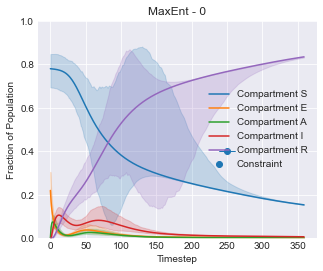

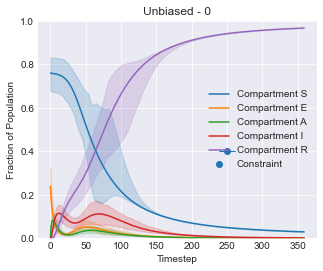

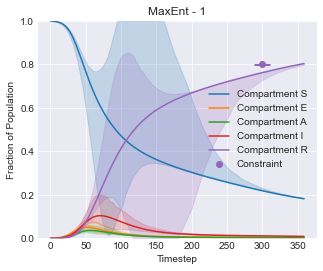

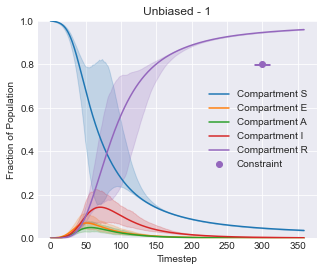

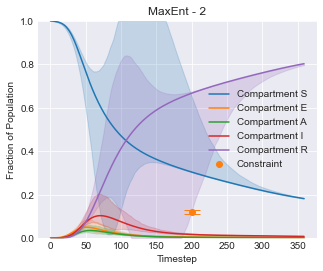

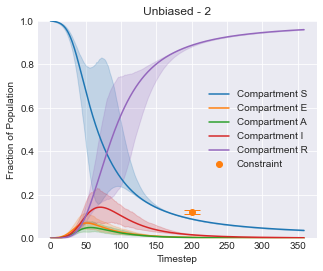

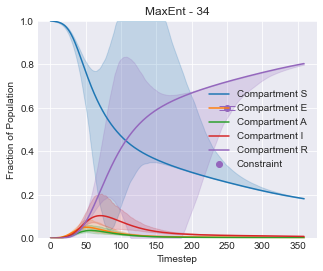

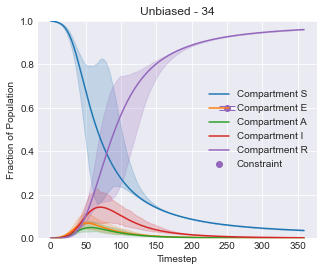

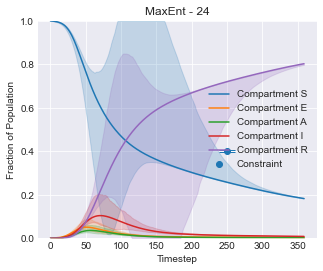

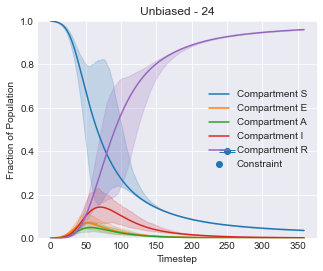

In [22]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()